# Assignment 2: Cell Tower Installation

## Instructions

This assignment is worth 10/100 points. 

You can do this assignment with someone else and it is about Local Search Algorithms, more specifically, Genetic Algorithms.

Answer to all the questions in english, argument, and justify your answers using the obtained results.

### Deadline
March 18th, 2023 at 23.59

### Some more Instructions
- You need to fill in your answers here and submit this jupyter notebook via NEO.
- It should run smoothly.
- Any compilation error will affect your total score. 


### Important before starting! 

- Only one of you should send the assignment, NOT BOTH!
- DO NOT copy the answers from internet nor from your classmates.
- If there are two or more groups that were discovered cheeting, then they will be penalized with 0/10.
- Use your brain and the material seen in class to program this assignment.
- You should be able to explain and modify your code according to your (or my) needs. 

## Problem Description
A local cellphone bolivian company wants to give cell phone signal to $n$ cities located in a remote place somewhere in Bolivia. 

They want to install cell towers that gives signal for $r$ Km around. The cost of installing a tower on land is not the same as the cost of installing it on a lake or on top of a hill. Thus, they want to minimize the amount of towers to be used and also the cost to be spent by installing each of them while giving signal to all cities (total coverage) such as in the picture below where we can see that all cities are covered. 

<div>
<img src="img/cities.png" width="500"/>
</div>


We will suppose that the signal radius of each tower is the same, independently if the tower is on top of a hill or on the land. 

### Some code to help you focus on the important part

We have already implemented part of the code to help you deal with some aspects of the problem such as the map representation, the cell tower coverage, part of the chromosome representation. 

In [175]:
import numpy as np
import random
from enum import Enum, auto
import copy
from matplotlib import colors, pyplot as plt
import matplotlib.patches as mpatches

In [176]:
class Chromosome: 
    rows = 0 
    cols = 0
    
    def __init__(self, gens):
        self.gens = gens
        # fitness function can be defined outside the class
        #self.ind_fitness = self.__class__.fitness_function(self.get_coordinates())
        self.fitness_fn = None
        self.prob = None

    @classmethod
    def generate_random(cls, tower_pr):
        '''
            It generates a random chromosome
            tower_pr is the probability to add a tower to a certain position
            higher this amount more towers you will have
            lower this amount less towers you will have
        '''
        gens = [0] * cls.rows * cls.cols 
        for i in range(cls.rows * cls.cols): 
            if random.random() < tower_pr:
                # indicates the presence of a tower
                gens[i] = 1 
        
        return Chromosome(gens)

    @classmethod 
    def set_fitness_function(cls, fun): 
        cls.fitness_function = fun

    def count_towers(self): 
        return sum(self.gens)  

    def get_coordinates(self): 
        ''' Maps gens to map coordinates '''
        r = self.__class__.rows 
        c = self.__class__.cols 
        matrix = [[None] * c for _ in range(r)] 
        
        for i in range(r): 
            for j in range(c): 
                matrix[i][j] = self.gens[i * r + j] 
        
        return np.array(matrix)
          
            

In [177]:
class SquareType(Enum): 
    water = auto() 
    land = auto() 
    hill = auto() 
    city = auto()

In [178]:
class Square: 
    def __init__(self, type, needs_coverage, tower_cost, is_covered = False): 
        self.tower_cost = tower_cost 
        self.needs_coverage = needs_coverage
        self.is_covered = is_covered 
        self.type = type 
        self.has_radar = False

In [179]:
class Landscape:
    def __init__(self, matrix): 
        self.matrix = matrix 
    
    def rows(self): 
        return len(self.matrix) 
    
    def cols(self): 
        return len(self.matrix[0])
    
    def add_towers(self, centroids, radius):
        r = radius
        # centroids is a 2d np array of 1s 0s
        for idx, x in np.ndenumerate(centroids):
            if centroids[idx[0],idx[1]] == 1:
                a, b = idx[0], idx[1]
                self.matrix[a][b].has_radar = True
                # draw the circle
                for y in range(self.rows()):
                    for x in range(self.cols()):
                        # see if we're close to (x-a)**2 + (y-b)**2 == r**2
                        if abs((x-a)**2 + (y-b)**2) <= r**2:
                            self.matrix[y][x].is_covered = True
                            
    def uncovered_count(self):
        '''uncovered cities'''
        count = 0
        
        for y in range(self.rows()):
            for x in range(self.cols()):
                if self.matrix[y][x].type == SquareType.city and self.matrix[y][x].is_covered == False:
                    count+=1
        return count
    # added
    def info_for_fitness(self):
      '''return (covered_cities, cost_towers)'''
      covered_cities = 0
      cost_towers = 0
      for y in range(self.rows()):
        for x in range(self.cols()):
          if self.matrix[y][x].type == SquareType.city and self.matrix[y][x].is_covered == True:
            covered_cities+=1
          if self.matrix[y][x].has_radar == True:
            cost_towers += self.matrix[y][x].tower_cost
      return covered_cities, cost_towers

In [180]:
def generate_random_landscape(points, weights, rows, cols): 
    matrix = [[None] * cols for _ in range(rows)] 
    for i in range(rows): 
        for j in range(cols): 
            p = random.choices(points, weights.values()) 
            square = copy.deepcopy(p[0])
            square.tower_cost = round(square.tower_cost * (1 + random.uniform(0, .1))) 
            matrix[i][j] = square 
    
    return Landscape(matrix)

plt.rcParams['figure.figsize'] = [5,5]

def plot_landscape(landscape): 
    square_colors = { 
        SquareType.water: 1, 
        SquareType.land: 11, 
        SquareType.hill: 21, 
        SquareType.city: 31
    }
    
    m = np.empty([landscape.rows(), landscape.cols()])
    
    for i in range(landscape.rows()):
        for j in range(landscape.cols()):
            m[i, j] = square_colors[landscape.matrix[i][j].type]
            
    col_list = ['blue', 'green', 'brown', 'black']
    labels = [s.name for s in square_colors.keys()] 
    cmap = colors.ListedColormap(col_list)
    bounds = [0, 10, 20, 30, 40] 
    norm = colors.BoundaryNorm(bounds, cmap.N) 
            
    plt.imshow(m, cmap = cmap, norm = norm) 
    plt.grid(which = 'major', axis = 'both', linestyle = '--', color = 'k', linewidth = 1) 
    patches = [mpatches.Patch(color = col_list[i], label = labels[i]) for i in range(len(col_list))]
    plt.legend(handles = patches, bbox_to_anchor=(1.3, 1), borderaxespad = 0.)
    plt.title('Landscape')
    plt.show()
    
def plot_coverage(landscape, title = "Coverage"):
    coverage_colors = { 
        'neutral': 1, 
        'is covered': 11, 
        'needs coverage': 21 
    }
    
    m = np.empty([landscape.rows(), landscape.cols()])
    for i in range(landscape.rows()):
        for j in range(landscape.cols()): 
            if landscape.matrix[i][j].is_covered: 
                m[i, j] = coverage_colors['is covered'] 
            elif not landscape.matrix[i][j].needs_coverage: 
                m[i, j] = coverage_colors['neutral'] 
            elif landscape.matrix[i][j].needs_coverage:
                m[i, j] = coverage_colors['needs coverage']

    col_list = ['white', 'yellow', 'black'] 
    labels = list(coverage_colors.keys()) 
    cmap = colors.ListedColormap(col_list) 
    bounds = [0, 10, 20, 30] 
    norm = colors.BoundaryNorm(bounds, cmap.N)
                
    plt.imshow(m, cmap = cmap, norm = norm)
    plt.grid(which = 'major', axis = 'both', linestyle = '--', color = 'k', linewidth = 1)
    patches = [mpatches.Patch(color = col_list[i], label = labels[i]) for i in range(len(col_list))]
    plt.legend(handles = patches, bbox_to_anchor=(1.5, 1), borderaxespad = 0.)
    plt.title('Coverage')
    plt.show() 

def plot_costs(landscape): 
    m = np.empty([landscape.rows(), landscape.cols()])
    
    for i in range(landscape.rows()): 
        for j in range(landscape.cols()): 
            m[i, j] = landscape.matrix[i][j].tower_cost 
    plt.imshow(m, cmap = plt.cm.Reds)
    plt.colorbar()
    plt.title('Tower Construction Costs')
    plt.show()
    
def plot_towers_position(landscape): 
    m = np.empty([landscape.rows(), landscape.cols()])
    
    for i in range(landscape.rows()): 
        for j in range(landscape.cols()): 
            if landscape.matrix[i][j].has_radar:
                m[j, i] = 11
            else:
                m[j, i] = 1

    col_list = ['white','black']
    cmap = colors.ListedColormap(col_list) 
    bounds = [0, 10, 20] 
    norm = colors.BoundaryNorm(bounds, cmap.N)
                
    plt.imshow(m, cmap = cmap, norm = norm)
    plt.title('Towers Position')
    plt.show()

The cost of installing a cell tower on:
- Water (such as lakes): \$us 300K
- City: \$us 200K
- Hill: \$us 100K
- Land: \$us 30K

Each tower has a coverage of 7 Km around it.

In [181]:
'''
# the purpose of this line is to reproduce your results
random.seed(15)
random.random()

# map dimension:
rows = 60
cols = 60

square_grid = { 
    Square(SquareType.water, needs_coverage = False, tower_cost = 300): 20,
    Square(SquareType.city, needs_coverage = True, tower_cost = 200): 1,
    Square(SquareType.hill, needs_coverage = False, tower_cost = 100): 8,
    Square(SquareType.land, needs_coverage = False, tower_cost = 30): 100
}

landscape = generate_random_landscape(list(square_grid.keys()), square_grid, rows, cols)

Chromosome.rows = rows
Chromosome.cols = cols

# fitness function undefined yet 
def fitness_function(coords): 
    return 0

Chromosome.set_fitness_function(fitness_function) 
cr = Chromosome.generate_random(.001) # ejemplo, donde esta creando un cromosoma 

test_landscape = copy.deepcopy(landscape) # hace una copia del landscape original 
# coverage of 7km

# le envia las coordenadas del cromosoma que tiene la posicion de torres y el radio de las torres y los aniade al mapa

test_landscape.add_towers(cr.get_coordinates(), 7) 

towers = cr.count_towers() 
uncovered = test_landscape.uncovered_count() 

print(f'# Cell Towers: {towers}') 
print(f'Uncovered Cities before cell towers: {landscape.uncovered_count()}')
print(f'Uncovered Cities after cell towers: {uncovered}')

plot_landscape(landscape) 
plot_costs(landscape) 
plot_coverage(landscape)

print('Coverage after setting up the cell towers:')
plot_coverage(test_landscape) 
plot_towers_position(test_landscape)

'''

"\n# the purpose of this line is to reproduce your results\nrandom.seed(15)\nrandom.random()\n\n# map dimension:\nrows = 60\ncols = 60\n\nsquare_grid = { \n    Square(SquareType.water, needs_coverage = False, tower_cost = 300): 20,\n    Square(SquareType.city, needs_coverage = True, tower_cost = 200): 1,\n    Square(SquareType.hill, needs_coverage = False, tower_cost = 100): 8,\n    Square(SquareType.land, needs_coverage = False, tower_cost = 30): 100\n}\n\nlandscape = generate_random_landscape(list(square_grid.keys()), square_grid, rows, cols)\n\nChromosome.rows = rows\nChromosome.cols = cols\n\n# fitness function undefined yet \ndef fitness_function(coords): \n    return 0\n\nChromosome.set_fitness_function(fitness_function) \ncr = Chromosome.generate_random(.001) # ejemplo, donde esta creando un cromosoma \n\ntest_landscape = copy.deepcopy(landscape) # hace una copia del landscape original \n# coverage of 7km\n\n# le envia las coordenadas del cromosoma que tiene la posicion de torre

## Tasks

1. Explain how you plan to use genetic algorithms to solve this problem and how your solution will work.
2. Implement a genetic algorithm to solve the problem. Plot the average fitness of the population for each generation.
3. Use different settings for the algorithm parameters (such as $p_c$, $p_m$, size of the population), report and disscuss your results. 
4. How does your solution look like? How many cell towers we need to use? What is the total cost of installing all of these? 

###**Answer 1**
####How I plan to use genetic algorithms to solve this problem: 
I plan to use genetic algorithms so that by iterating many times a group of possible solutions (each one associated with a probability that is maximized according to how good the solution is), it creates, in each iteration, daughter solutions (combinations of two good solutions) chosen randomly according to its probability.

In this problem, a possible solution (chromosome) is a configuration of zeros and ones that indicates the number of towers that exist on a map and that is associated with a number that indicates how good this configuration is for the problem to be solved.

Now, with the passing of the iterations, this methodology will create increasingly better solutions (maps with optimal tower positions) in order to cover the largest number of cities with the lowest investment cost in towers. In this way the algorithm will end when some solution is quite good (when it finds a chromosome with a  very high fitness) or when enough time has passed.

####How my solution works:
Before answering this question I will show de modifications that I made to the original code: 


1.   to the Chromosome Class:
  Since each chromosome has a fitness_function and a probability associated with it, I added this last attribute to the chromosome class and changed the inputs of the function that gave us the value of the fitness_function.

  In this way, a chromosome would have:
  - gens:  a list (squashed matrix of zeros and ones) where 1's indicate the presence of towers and 0's, the absence of these.
  - fitness_fun: a number that is maximized according to how good the solution given by the chromosome is and that is determined by the number of cities covered and the price of the towers that cover them.
  - prob: a percentage that indicates the probability that the chromosome has of being selected.
2.   to the Landscape Class: Since the fitness_function I worked with is based on the number of cities covered, I found it necessary to determine this value through a function. In addition to this, I saw that this same function could be used to also find the cost of the towers associated with that coverage. In this way, I ended up generating the ` information_for_fitness ` function that returns the covered_cities and the cost_towers values which will be used to find the fitness value of each chromosome.


**Generate an initial population**

As a first step, I generated an initial population of chromosomes with n number of them. The number of elements in the population was determined by the parameter `population_size`. To do this I used the `generate_random` method of the chromosome class which creates random genes and put it in a loop with the number of n chromosomes I wanted to generate.

The parameter `prob` (parameter of the generate_random method) that I used was a random number in the order of thousandths so as not to generate too many towers. This is because the number of cities facing land, water or mountains is less than 1% of the total for the entire map. So in any solution to this problem, the number of towers placed should not be equal to or greater than the number of cities. In fact, a good solution should not have a number of towers greater than 50% of the number of cities.


**Fitness function**
As a second step, a fitness function is defined. The fitness function I chose is determined by the number of cities covered plus the cost of the towers used. However, I considered that in this problem the fact of covering the cities is more important than the cost that they involve, so I multiplied a number to the number of cities covered in order to give more weight to this variable. The number that I multiplied was 1000 because this number is in the range of the number that determines the cost of the towers.



*Observation*: at the beginning I had chosen to work with a fitness function that divided the number of covered cities by the cost of towers. This is because: the greater the number of cities covered, the greater fitness we obtain and the greater the cost, the fitness reduces (cities covered directly proportional to fitness and cost inversely proportional to fitness).

  However, this logic has a problem. And it is that both variables are related. So, if there are few covered cities, the cost will also be small and the result of this division will be higher compared to a solution with more covered cities and therefore with a higher cost. This is why this solution, instead of maximizing the best solution, minimizes it and maximizes the worst result.

  To check this, you can uncomment the different fitness function options with which I was experimenting. Option 1 and 3 return bad fitness functions and option 2, 4 and 5 return optimal fitness. In this lab I decided to work with option 2 of the fitness function.

  You could also see the following table to compare the performances mentioned before:







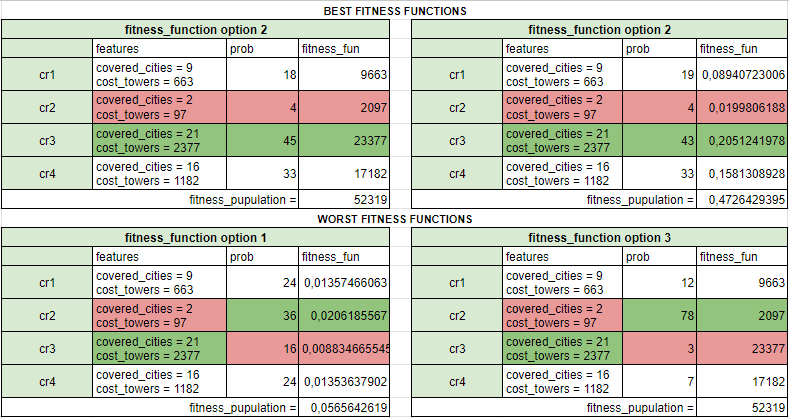

This table was created from tests that were carried out with the chromosomes of the initial population. Probability values appear rounded. Also, the option 4 table has been omitted because its only a modification of the  fitness function - option 5.

**Join landscape and chromosome gens / fitness population and chromosome probabilities**

Until now we have been using the information from a separate chromosome, we have not seen the effects of the genes of the chromosome when we superimpose them on the lanscape. And this is necessary to determine the value of the fitness function and the probability that each chromosome has. So, with the `fitness_allocator` function we superimpose the genes of each chromosome of the initial population and find the fitness associated with each of them, we also assign it to the value of its attribute. With this, our chromosome would have the gens and fitness_function attributes filled.


Now, with the information obtained by the fitness_allocator, we will complete the last empty attribute of the chromosome, the probability (prob). To do this, I created another function called `prob_allocator_and_useful_values_based_on_fitness`, which, as the name says, will also provide me with fitness-related values that will be useful later.


*Up to this point we already have a full-fledged population, with chromosomes that each have genes, fitness and probabilities.*

**Create new stronger generations, evolution and natural selection**

From this point we will be creating new generations. The idea is that given the initial population that we have already created, we reproduce and randomly mutate the chromosomes that offer the best solutions until we have a generation of offsprings of the same size as the initial population and this will iterate num_generations times.


This process is explained in more detail in the code, but in summary, once the chromosomes chosen by weights and randomly have reproduced and/or mutated, the resulting offsprings will go through the same process: overlapping the landscape, fitness assignment and probability assignment. Once this is done, they will just be taken into account in a generation that we will call new_population_full_filled.


The algorithm will end when the n-num_genetarions have passed and will return a list with the fitness percentages of each generation and a list with the best performing chromosomes in each generation.


###**Answer 2**
Please, run the entire code on each modification or after uncommenting. Since my code is linked to everything and everywhere, if a cell does not run after even a minor modification then the genetic_algorithm function returns the error "division by zero"

In [182]:
random.seed(15)
random.random()

# map dimension:
rows = 60
cols = 60

radius = 7

square_grid = { 
    Square(SquareType.water, needs_coverage = False, tower_cost = 300): 20, #que es esto
    Square(SquareType.city, needs_coverage = True, tower_cost = 200): 1,
    Square(SquareType.hill, needs_coverage = False, tower_cost = 100): 8,
    Square(SquareType.land, needs_coverage = False, tower_cost = 30): 100
}

landscape = generate_random_landscape(list(square_grid.keys()), square_grid, rows, cols)

Chromosome.rows = rows
Chromosome.cols = cols

# An initial population is generated with n random chromosomes
population_size = 10
population = []

for x in range(population_size):
  prob = random.random()*0.01 # we don't want many towers
  population.append(Chromosome.generate_random(prob))
print(population[0].gens)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [183]:
'''
# fitness function - option 1
def fitness_function(covered_count, cost_towers): 
    f_fn = covered_count/cost_towers
    return f_fn
'''

# fitness function - option 2
def fitness_function(covered_count, cost_towers): 
    f_fn = (covered_count*1000)+cost_towers
    return f_fn

'''
# fitness function - option 3
def fitness_function(covered_count, cost_towers): 
    f_fn = (covered_count+1000)/(cost_towers+1) # plus 1 to avoid problem infinities
    return f_fn
'''
'''
# fitness function - option 4
def fitness_function(covered_count, cost_towers): 
    f_fn = (covered_count*1000)/(cost_towers+1000) 
    return f_fn
'''

'''
# fitness function - option 5
def fitness_function(covered_count, cost_towers): 
    f_fn = (covered_count*1000)/(cost_towers+10000) 
    return f_fn
'''

# create n landscapes with the configuration of each chromosome, this also saves the fitness values in  the attributes of each chromosome
def fitness_allocator(population, landscape): # this functions is also a joiner, it joins the landscape and the configuration of a gen
  f_fn_list = []
  for x in range(len(population)):
    test_landscape = copy.deepcopy(landscape)
    test_landscape.add_towers(population[x].get_coordinates(), radius) 
    covered_count, cost_towers = test_landscape.info_for_fitness()
    population[x].fitness_fn = fitness_function(covered_count, cost_towers)
    f_fn_list.append(fitness_function(covered_count, cost_towers))

    #print
  return  f_fn_list, population # returns a population chromosomes that have gens and fitness values filled


def prob_allocator_and_useful_values_based_on_fitness(f_fn_list, population_fitness_filled): # recives the population with have gens and fitness values filled 
  '''
  rerturns the sum of the fitness values of each chromosome in a population, 
  a list of chromosome probabilities and the official population'''

  fitness_population = sum(f_fn_list) 
  prob_cr_list = []
  for x in range(len(population_fitness_filled)):
    prob_cr = ((population_fitness_filled[x].fitness_fn)/fitness_population)*100
    population_fitness_filled[x].prob = prob_cr # with this we have all the atributes filled, a complete chromosome is born
    prob_cr_list.append(prob_cr) # list of probabilities
  return fitness_population, prob_cr_list, population_fitness_filled # returns the official population 


In [184]:
# cut locations
cross_point = random.randint(1000,2000) # try to cut at middle
# cut wherever (0,3599)
cross_point_array = np.random.randint(1000,2000, 2)
mutation_point = random.randint(1000,2000) # 

prob_crossover = 0.7  #change to 0.2 for answer 3
prob_mutation = 0.1  #change to 0.8

In [185]:
#inspired by: https://medium.com/@samiran.bera/crossover-operator-the-heart-of-genetic-algorithm-6c0fdcb405c0

# Single-Point crossover 
def single_point_crossover(cr_1_gens, cr_2_gens, cross_point):
  cr_child_1_gens = np.append(cr_1_gens[:cross_point], cr_2_gens[cross_point:])
  cr_child_2_gens = np.append(cr_2_gens[:cross_point], cr_1_gens[cross_point:])
  return cr_child_1_gens, cr_child_2_gens

# Multi-Point Crossover
def multi_point_crossover(cr_1_gens, cr_2_gens, cross_point_array):
  for i in cross_point_array:
    cr_1_gens, cr_2_gens = single_point_crossover(cr_1_gens, cr_2_gens, i)
  return cr_1_gens, cr_2_gens

# Mutation 
def mutation(cr_gens, mutation_point):
  cr_gens[mutation_point] = random.randint(0,1)
  return cr_gens

In [186]:
num_generations = 60

# creation of the first generation
'''
fitness_allocator recives a landscape and the first population, the one that have chromosomes with only gens information.
It returns a population with chromosomes that now also have a fitness value.
'''
f_fn_list, population_fitness_filled = fitness_allocator(population, landscape) 

'''
This new population that has slightly more complete information on its chromosomes is passed as a parameter to the function 
that will finish filling all the values of the chromosome.
'''
fitness_population, prob_cr_list, population_full_filled = prob_allocator_and_useful_values_based_on_fitness(f_fn_list, population_fitness_filled)


def genetic_algoritm(population_full_filled, prob_cr_list, landspcape): 
  average_fitness_per_generation = []
  best_chromosome_per_generation = []
  for i in range(num_generations): #num generacion
    new_population = []
    while len(new_population)<len(population_full_filled):
      # select 2 chromosomes at random taking into account their probabilities
      select_chromosomes = random.choices(population_full_filled, prob_cr_list, k = 2) # object list

      # copy chromosomes so as not to modify the values ​​of the original population, these are copies with these are copies with complete chromosome information
      cr_1 = copy.deepcopy(select_chromosomes[0])
      cr_2 = copy.deepcopy(select_chromosomes[1]) 

      # transform lists into numpy arrays to facilitate handling, notice that I'm only handling with the genes
      cr_1_gens = np.array(cr_1.gens)
      cr_2_gens = np.array(cr_2.gens)
      if random.random()<=prob_crossover:
        cr_z_gens, cr_a_gens = single_point_crossover(cr_1_gens, cr_2_gens, cross_point)
      else:
        cr_z_gens, cr_a_gens =  cr_1_gens, cr_2_gens

      # mutation
      if random.random()<=prob_mutation:
        cr_z_gens = mutation(cr_1_gens, mutation_point)
      if random.random()<=prob_mutation:
        cr_a_gens = mutation(cr_2_gens, mutation_point)
  
      '''
      until here we have np arrays of gens of 2 new chromosomes, we have to join this new ones to the landscape 
      and calculate the other atributes of the chromosomes
      '''
      # I worked with python lists in the beginning so now I have to convert my arrays to lists again and add them to the new population
      new_cr1 = Chromosome(cr_z_gens.tolist())
      new_cr2 = Chromosome(cr_a_gens.tolist())
      
      # adding chromosomes with only gens information
      new_population.append(new_cr1)
      new_population.append(new_cr2)
    
    '''
    Once all the offspring have been added to the new population, join this population with the landscape 
    and finish filling the chromosome attributes (with fitness and prob)
    '''
    f_fn_list, new_population_fitness_filled = fitness_allocator(new_population, landscape) 
    sum_fitness, prob_cr_list, new_population_full_filled = prob_allocator_and_useful_values_based_on_fitness(f_fn_list, new_population_fitness_filled)
  
    # calculate average fitness per generation and find the best chromosome per generation
    average_fitness_per_generation.append(sum_fitness/len(new_population_full_filled))
    max_fitness =  max(f_fn_list) # highest fitness
    index = f_fn_list.index(max_fitness) # index of the best chromosome
    best_chromosome_per_generation.append(new_population_full_filled[index]) # object list

    population_full_filled.clear()# empty it
    population_full_filled = copy.deepcopy(new_population_full_filled)
  

  return average_fitness_per_generation, best_chromosome_per_generation


average_fitness_per_generation, best_chromosome_per_generation = genetic_algoritm(population_full_filled, prob_cr_list, landscape)
print(average_fitness_per_generation)
print(best_chromosome_per_generation[-1].gens)
print(best_chromosome_per_generation[-1].fitness_fn)
print(best_chromosome_per_generation[-1].prob)

  

[17034.4, 22643.0, 23359.1, 24693.5, 23741.7, 24217.6, 23741.7, 23741.7, 23265.8, 24693.5, 25169.4, 24693.5, 24693.5, 24214.6, 25642.3, 27070.0, 27070.0, 27073.0, 27073.0, 27073.0, 27070.0, 27070.0, 27073.0, 27073.0, 27073.0, 27070.0, 27064.0, 27061.0, 27061.0, 27055.0, 27064.0, 27061.0, 27058.0, 27058.0, 27061.0, 27067.0, 27061.0, 27055.0, 27052.0, 27049.0, 27052.0, 27061.0, 27055.0, 27055.0, 27049.0, 27049.0, 27049.0, 27046.0, 27049.0, 27058.0, 27052.0, 27049.0, 27058.0, 27061.0, 27061.0, 27055.0, 27058.0, 27061.0, 27064.0, 27064.0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Cell Towers: 33
Uncovered Cities before cell towers: 31
Uncovered Cities after cell towers: 7


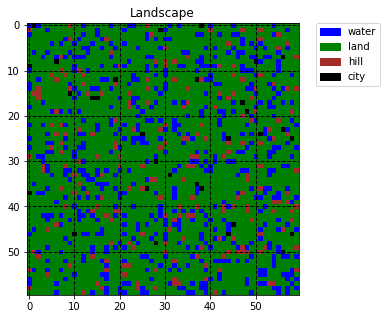

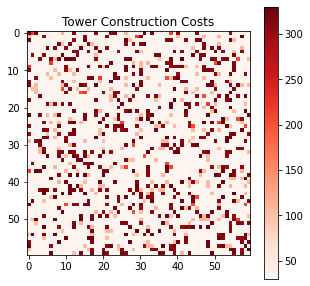

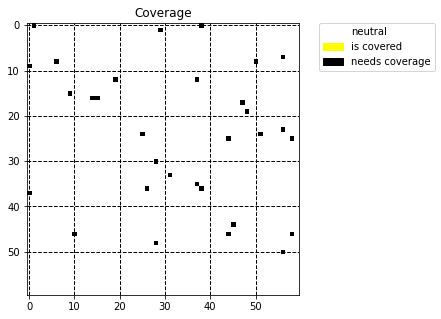

Coverage after setting up the cell towers:


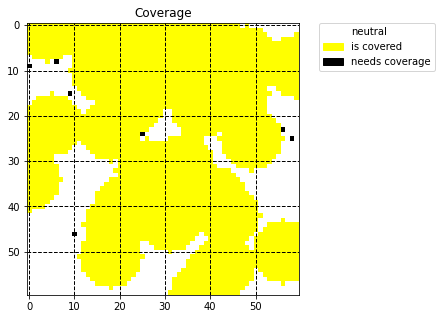

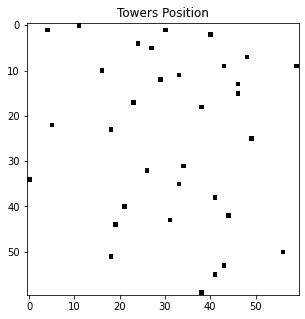

In [187]:
# graphics with the number of towers used and cities covered
test_landscape = copy.deepcopy(landscape) 
test_landscape.add_towers(best_chromosome_per_generation[-1].get_coordinates(), 7) 

towers = best_chromosome_per_generation[-1].count_towers() 
uncovered = test_landscape.uncovered_count() 

print(f'# Cell Towers: {towers}') 
print(f'Uncovered Cities before cell towers: {landscape.uncovered_count()}')
print(f'Uncovered Cities after cell towers: {uncovered}')

plot_landscape(landscape) 
plot_costs(landscape) 
plot_coverage(landscape)

print('Coverage after setting up the cell towers:')
plot_coverage(test_landscape) 
plot_towers_position(test_landscape)

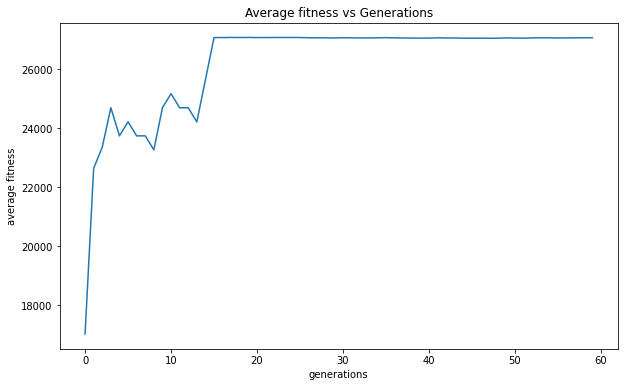

In [188]:
# inspired by: https://www.delftstack.com/es/howto/matplotlib/how-to-change-the-size-and-format-of-a-figure-in-matplotlib/
#fig, ax = plt.subplots()
#ax.scatter(x =  range(0, num_generations) , y = average_fitness_per_generation)
plt.figure(figsize=(10,6))
plt.plot(range(0, num_generations) ,  average_fitness_per_generation)
plt.title('Average fitness vs Generations')
plt.xlabel('generations')
plt.ylabel('average fitness')

plt.show()

Just for verification purposes, I initially worked with a population of 4 chromosomes and carried out iterations of 10 and 100 generations with them.
In the following table you can see the results, these do not vary too much due to the low number of chromosomes that the population has, but in the graph it can be seen that the generations become stronger with each iteration, so on average, the fitness of the population is increasing.

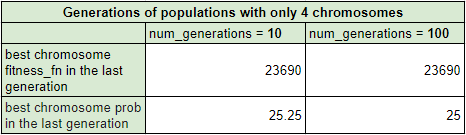

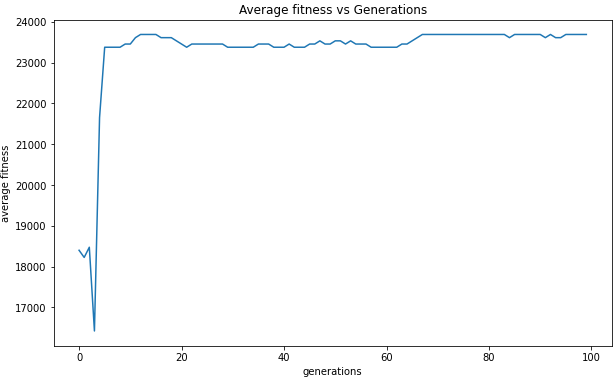

The algorithm will most likely perform better if the number of chromosomes is increased (to 200, 500, 1000, or maybe 2000). However, due to the computing time it takes to iterate these values, I only worked with populations of 100 and 30 chromosomes with iterations of 200 generations. 

It can be seen in the graph that the best results are reached from the 60th generation onwards and from there the values are maintained.

100 chromosomes with 200 generations has a best chromosome
  - fitness_fn in the last generation = 34551
  - best chromosome prob in the last generation = 1.0005096515257692

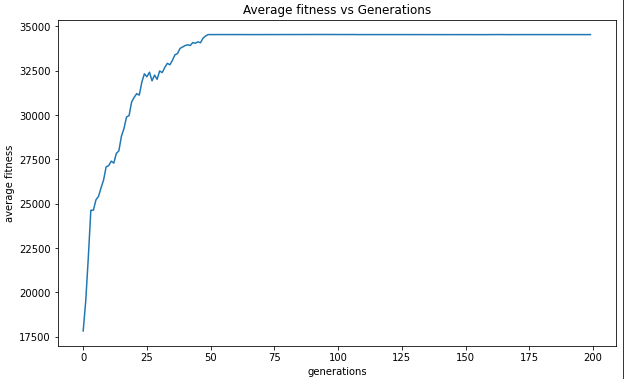

##**Answer 3**
By experimenting with the algorithm I came to the conclusion that the prob_crossover must be a number in the range 0.5 to 0.9 for there to be at least some chance of crossover. And since this algorithm is based in nature, the prob_mutation must be small. If the number of prob_mutation is higher, the randomness will increase and we will reach the desired result in more time than necessary since it will constantly deviate from the objective. On the other hand, if the prob_crossover is small, it will also take longer to reach the solution because most of the time we will be avoiding reproducing the chromosomes.

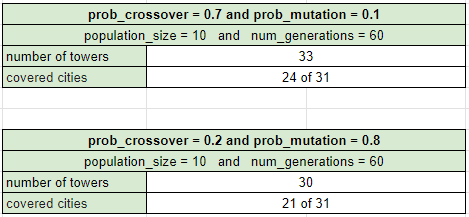

##**Answer 4**


- 43 towers with all the cities covered using 100 chromosomes in 200 iterations. However, this result is not very good because you are using a number of towers that exceeds the number of cities.

- 33 towers with 24  cities covered using 10 chromosomes in 60 iterations. 

I believe that experimenting with different values we can reach the best answer







#Observations
**to test -** a good indicator to terminate the algorithm could also be: terminate the loop when you have a generation in which all chromosomes have a landscape.uncovered_count = 0, and return the chromosome that has the best fitness among them (so that also take into account the associated cost).

**to test -** try 20 chromosomes in 100 generations

**consider -** Running the code with 100 chromosomes in 200 generations takes about 1 hour.